In [1]:
%load_ext autoreload
%autoreload 2
import torch
from Feat2Annot import *
import numpy as np
from torch.utils.data import DataLoader

In [2]:
from util import prepare_dataset

dataset = prepare_dataset("./data", 15)
print(dataset.get_annot_class())

689459it [00:00, 2298458.24it/s]                            


7


In [3]:
batch_size = 32
generator = torch.Generator().manual_seed(42)
train_data, val_data = torch.utils.data.random_split(dataset, (0.9, 0.1), generator)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=1)

In [4]:
model = Feat2AnnotModel(
    input_size=200, hidden_size=1024, target_class=dataset.get_annot_class()
)

In [6]:
trainiter = iter(train_loader)
train_feat, train_label = next(trainiter)
model(train_feat, train_label)

torch.Size([32, 15])


tensor([-62.1464, -62.1368, -62.1925, -62.2745, -62.0747, -62.0972, -62.0385,
        -62.0417, -62.2355, -62.1305, -62.3023, -62.3750, -62.3284, -62.2789,
        -62.2690], grad_fn=<SumBackward1>)

In [5]:
### Initial model score
from tqdm import tqdm
from torcheval import metrics

metric = metrics.MulticlassAccuracy()
metric.reset()
model.eval()
for source_feature, tgt_annot in tqdm(val_loader):
    annot_hypothesis = model.beam_search(source_feature, 1)
    annot_hat = torch.tensor(annot_hypothesis[0].value, dtype=torch.int64)
    metric.update(annot_hat, tgt_annot.squeeze(0))
init_valid_metric = metric.compute()

100%|██████████| 2849/2849 [01:22<00:00, 34.58it/s]


In [6]:
### Run one episode of training
num_epoch = 1
training_losses = []
val_losses = []
val_metric = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(num_epoch):
    metric.reset()
    model.train()
    for xbatch, ybatch in tqdm(train_loader):
        output = model(xbatch, ybatch)
        loss = -output
        batch_loss = loss.sum()
        loss = batch_loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for xval_batch, yval_batch in tqdm(val_loader):
            output = model(xval_batch, yval_batch)
            val_loss = -output.sum() / batch_size
            annot_hypothesis = model.beam_search(source_feature, 1)
            annot_hat = torch.tensor(annot_hypothesis[0].value, dtype=torch.int64)
            metric.update(annot_hat, tgt_annot.squeeze(0))
        val_metric.append(metric.compute())

    print(
        f"epoch {epoch+1}/{num_epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}"
    )
    training_losses.append(loss.item())
    val_losses.append(val_loss.item())

100%|██████████| 2849/2849 [02:32<00:00, 18.69it/s]

epoch 1/1, Training Loss: 0.025412341579794884, Validation Loss: 6.503552867798135e-05


In [7]:
print(f"naive model val accuracy {init_valid_metric}")
print(f"after one episode of training {val_metric[-1]}")

naive model val accuracy 0.17463436722755432
after one episode of training 0.7333333492279053


In [24]:
model.eval()
new_val_loader = DataLoader(
    dataset=val_loader.dataset,
    batch_size=1,
    shuffle=True,
)
dataiter = iter(new_val_loader)
source_feature, target_seq = next(dataiter)
annot_hypothesis = model.beam_search(source_feature, 1)
annot_hat = torch.tensor(annot_hypothesis[0].value, dtype=torch.int64)
print(f"target {target_seq}")
print(f"predicted {annot_hat}")

target tensor([[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
predicted tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [17]:
## load params
# load model
params = torch.load("model.bin", map_location=lambda storage, loc: storage)
model.load_state_dict(params["state_dict"])

<All keys matched successfully>

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.50000000e-01 9.37500000e-01 2.34375000e-01 5.85937500e-02
 1.46484375e-02 3.66210938e-03 9.15527344e-04 2.28881836e-04
 5.72204590e-05 1.43051147e-05 3.57627869e-06] [0.0124657  0.0498628  0.19945121 0.79780483 0.19121933 0.76487732
 0.05950928 0.23803711 0.95214844 0.80859375 0.234375   0.9375
 0.75       0.         0.        ]


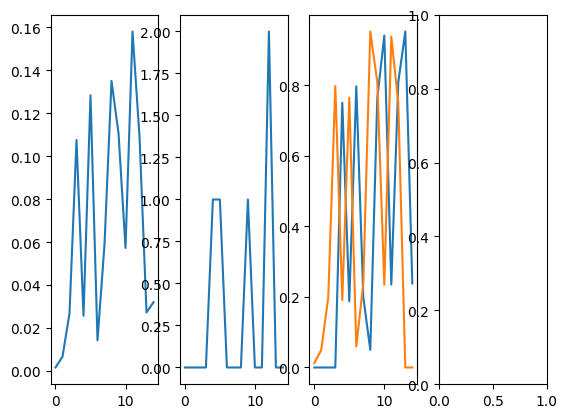

In [29]:
a = torch.tensor(
    [
        [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0],
    ]
)
b, c, d = exponential_weight(a, 0.25)
from matplotlib import pyplot

fig, axes = pyplot.subplots(1, 4)
axes[0].plot(b[1, :])
axes[1].plot(a[1, :])
axes[2].plot(c[1, :])
axes[2].plot(d[1, :])
print(c[0, :], d[1, :])